# **Data Mining**
## First Home Assignment 

- Diogo Araújo, fcxxxxx - X H
- Joel Oliveira, fc59442 - X H
- João Braz, fcxxxxx - X H

### Objective 1 - Dimensionality Reduction

1. #### **PCA**

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from mlxtend.plotting import 

from scipy.sparse import dok_matrix, csc_matrix
from scipy.sparse.linalg import svds

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [84]:
data = pd.read_csv("train.csv")
#data = StandardScaler().fit_transform(data)

X = data.drop(columns="critical_temp")
X_scaled = StandardScaler().fit_transform(X)
y = data["critical_temp"]


Text(0, 0.5, 'Variance Explained')

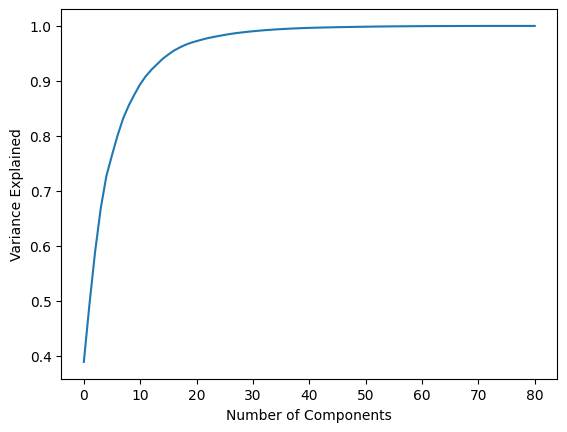

In [85]:
pca = PCA(n_components=81).fit(X_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained")

In [86]:
np.cumsum(pca.explained_variance_ratio_)[:12]

array([0.38931798, 0.49414007, 0.58935207, 0.66842937, 0.7272512 ,
       0.76513489, 0.8013574 , 0.83242847, 0.8560396 , 0.87581839,
       0.89410206, 0.90868803])

- We can see that with 2 Components we have 92% of the variance explained. This is a massive compression in the amount of information needed.
- If scaled the components needed are 12

In [91]:
pca = PCA(n_components=12).fit(X_scaled)
pca.transform(X_scaled).shape

(21263, 12)

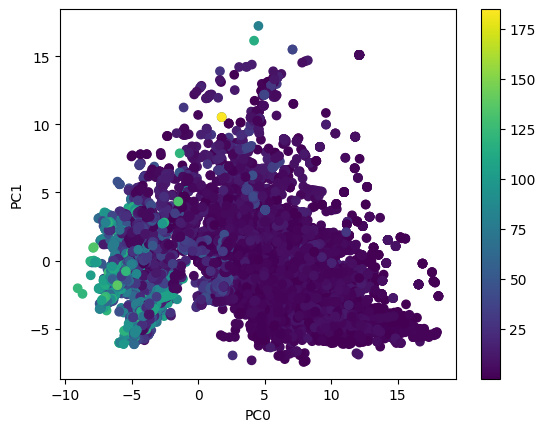

In [92]:
X_transformed = pca.transform(X_scaled)
plt.scatter(X_transformed[:,0], X_transformed[:,1], c=y)
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.colorbar()

2. #### **SVD**

In [93]:
s = np.linalg.svd(X_scaled, compute_uv=False)

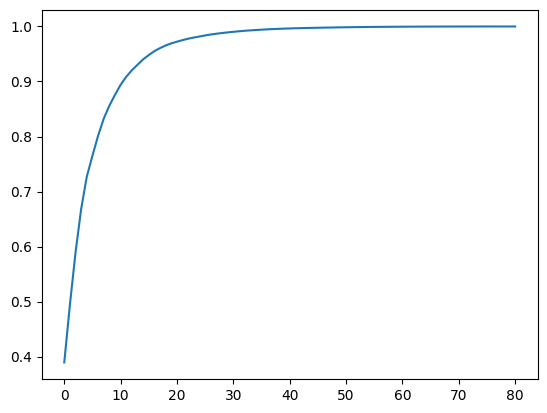

In [94]:
plt.plot(
    (np.cumsum(
        s**2/(s**2).sum()
    ))
)

In [96]:
(np.cumsum(
        s**2/(s**2).sum()
    ))[:12]

array([0.38931798, 0.49414007, 0.58935207, 0.66842937, 0.7272512 ,
       0.76513489, 0.8013574 , 0.83242847, 0.8560396 , 0.87581839,
       0.89410206, 0.90868803])

- Also only 2 concepts to reach 90% of the relevance of the concepts
- If scaled, the same 12 concepts

In [97]:
u,s,v = svds(dok_matrix(X_scaled), k=12)

In [98]:
u.shape, s.shape, v.shape

((21263, 12), (12,), (12, 81))

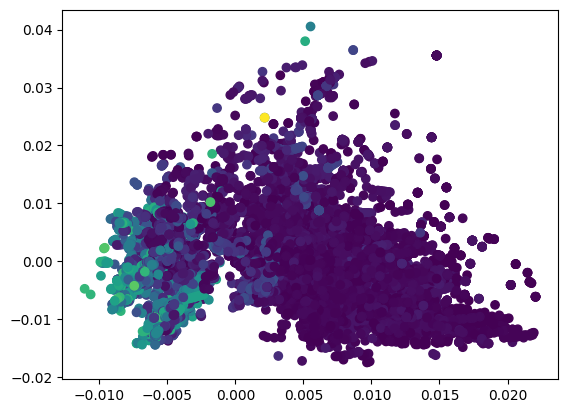

In [100]:
plt.scatter(u[:, -1], u[:, -2], c=y)

 - Results similar to pca but more compressed. It seems that SVD got a decomposition with a more correlated relation

### Objective 2 - Create a Regression and classification model


#### 2.1 Make a Regression Model
Since we decorrelated the features using PCA, we think that Linear Regression will not have good results, therefore we will use DecisionTree Regression

In [101]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, max_error

from time import time

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

- ##### Regression in the whole dataset

In [103]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

tick = time()
dtr = DecisionTreeRegressor().fit(X_train, y_train)
print(time() - tick)

tick = time()
lr = LinearRegression().fit(X_train, y_train)
print(time() - tick)

1.2877674102783203
0.10904145240783691


In [104]:
X_test = scaler.transform(X_test)
preds = dtr.predict(X_test)
preds2 = lr.predict(X_test)

MSE = 11.827238445538953
Max Error = 111.0


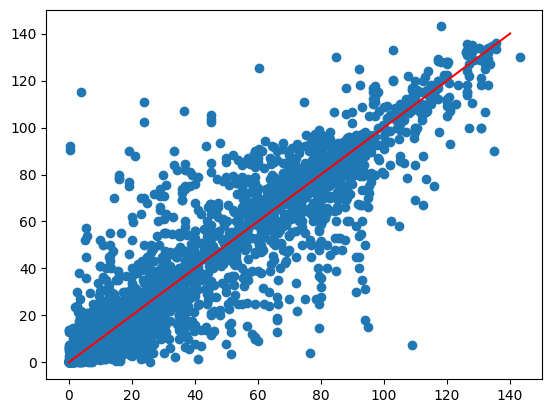

In [105]:
print("MSE =", mean_squared_error(y_test, preds, squared=False))
print("Max Error =", max_error(y_test, preds))

plt.scatter(preds, y_test)
plt.plot([0, 140], [0,140], "r")

MSE = 17.789724339904463
Max Error = 84.36296216474379


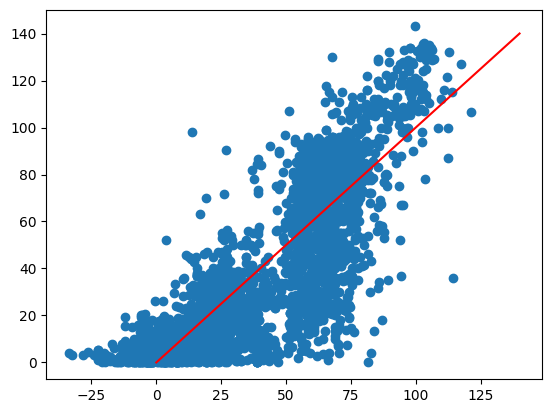

In [106]:
print("MSE =", mean_squared_error(y_test, preds2, squared=False))
print("Max Error =", max_error(y_test, preds2))

plt.scatter(preds2, y_test)
plt.plot([0, 140], [0,140], "r")

- ##### Regression in the reduced dataset

In [109]:
tick=time()
dtr = Pipeline([
                ("scaler", StandardScaler()),
                ("pca", PCA(n_components=12)),
                ("predictor", DecisionTreeRegressor())
               ]).fit(X_train, y_train)
print(time()-tick)

tick=time()
lr = Pipeline([
                ("scaler", StandardScaler()),
                ("pca", PCA(n_components=12)),
                ("predictor", LinearRegression())
               ]).fit(X_train, y_train)
print(time()-tick)

0.40498876571655273
0.11995148658752441


> even with one additional processing step, the training time of the model was faster

MSE = 13.438157506014997
Max Error = 125.0


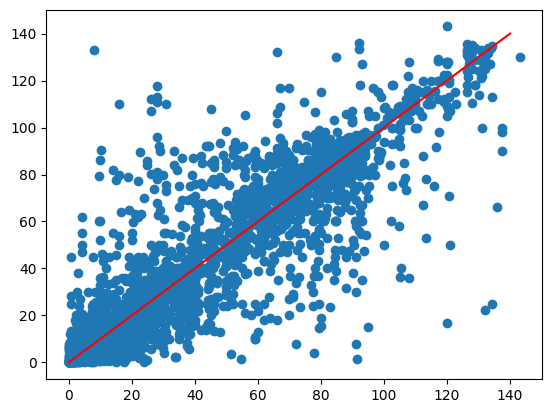

In [110]:
preds = dtr.predict(X_test)
preds2 = lr.predict(X_test)

print("MSE =", mean_squared_error(y_test, preds, squared=False))
print("Max Error =", max_error(y_test, preds))

plt.scatter(preds, y_test)
plt.plot([0, 140], [0,140], "r")

MSE = 22.271363770151098
Max Error = 135.60982083537945


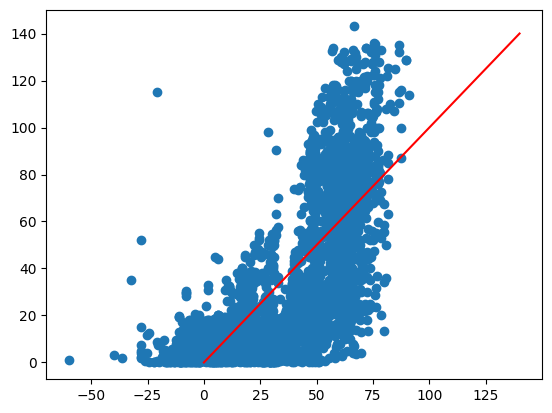

In [111]:
print("MSE =", mean_squared_error(y_test, preds2, squared=False))
print("Max Error =", max_error(y_test, preds2))

plt.scatter(preds2, y_test)
plt.plot([0, 140], [0,140], "r")

The correlation of the results is higher, and both max_error and mse reduced

#### 2.2 Make a Classification Model

In [112]:
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [113]:
def to_class(x: float) -> str:
    if 0 <= x < 1.0:
        return "VeryLow"
    elif 1 <= x < 5.0:
        return "Low"
    elif 5 <= x < 20.0:
        return "Medium"
    elif 20 <= x < 100.0:
        return "High"
    elif x >= 100:
        return "VeryHigh"
    return None

In [118]:
y_class = y.apply(lambda x: to_class(x))
y_train = y_train.apply(lambda x: to_class(x))
y_test = y_test.apply(lambda x: to_class(x))

enc = LabelEncoder().fit(y_class)

y_class_enc = enc.transform(y_class)
y_train = enc.transform(y_train)
y_test = enc.transform(y_test)


- #### Full Dataset
    1. Naive Bayes

In [119]:
X_train_scaled = scaler.transform(X_train)

tick = time()
nb = GaussianNB().fit(X_train_scaled, y_train)
print(time()-tick)

0.03005528450012207


In [120]:
X_test_scaled=scaler.transform(X_test)
preds=nb.predict(X_test_scaled)

Acc = 0.516811662355984
              precision    recall  f1-score   support

           0       0.80      0.61      0.69      1957
           1       0.49      0.44      0.47       813
           2       0.46      0.34      0.39      1106
           3       0.21      0.93      0.34       168
           4       0.24      0.50      0.32       209

    accuracy                           0.52      4253
   macro avg       0.44      0.57      0.44      4253
weighted avg       0.60      0.52      0.54      4253



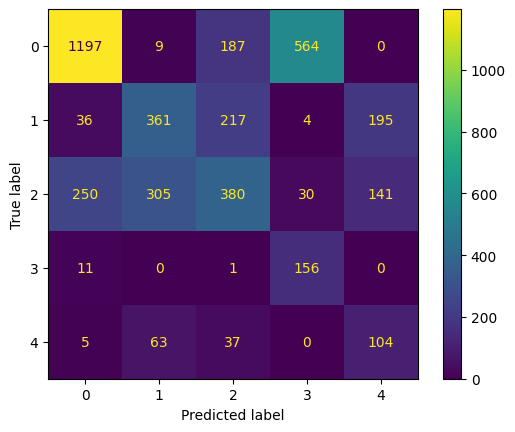

In [121]:
print("Acc =", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

ConfusionMatrixDisplay(
    confusion_matrix(y_test, preds)
).plot()

Accuracy of 50%, very low <br>
F1 score not good enough for most of the categories

    2. Decision Tree

In [122]:
tick = time()
dtc = DecisionTreeClassifier().fit(X_train_scaled, y_train)
print(time()-tick)

1.471391201019287


Substancial more time for this small dataset

In [123]:
preds=dtc.predict(X_test_scaled)

Acc = 0.8469315777098518
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1957
           1       0.78      0.80      0.79       813
           2       0.80      0.77      0.79      1106
           3       0.81      0.82      0.82       168
           4       0.73      0.69      0.71       209

    accuracy                           0.85      4253
   macro avg       0.81      0.80      0.81      4253
weighted avg       0.85      0.85      0.85      4253



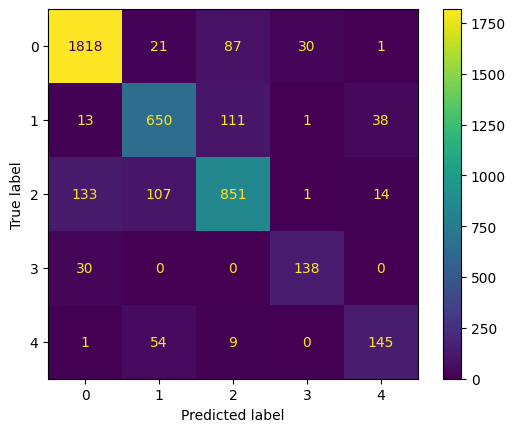

In [124]:
print("Acc =", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

ConfusionMatrixDisplay(
    confusion_matrix(y_test, preds)
).plot()

However, results are much better than NaiveBayes. <br>
Could be because the variables are not independent amongst themselves, as Naive Bayes assumes

- #### Reduced Dataset
    1. Naive Bayes

In [131]:
tick = time()
nb = Pipeline([
                ("scaler", StandardScaler()),
                ("pca", PCA(n_components=12)),
               ("predictor", GaussianNB())
              ]).fit(X_train, y_train)
print(time()-tick)

0.15429139137268066


Acc = 0.6468375264519163
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1957
           1       0.55      0.41      0.47       813
           2       0.47      0.53      0.50      1106
           3       0.60      0.58      0.59       168
           4       0.36      0.40      0.38       209

    accuracy                           0.65      4253
   macro avg       0.56      0.55      0.55      4253
weighted avg       0.65      0.65      0.64      4253



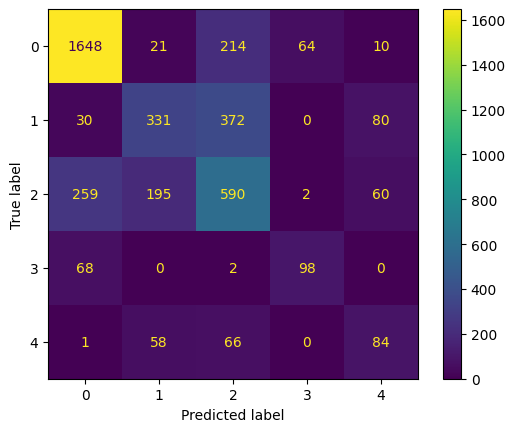

In [132]:
preds=nb.predict(X_test)
print("Acc =", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

ConfusionMatrixDisplay(
    confusion_matrix(y_test, preds)
).plot()

    2. Decision Tree

In [133]:
tick = time()
dtc = Pipeline([
                ("scaler", StandardScaler()),
                ("pca", PCA(n_components=12)),
               ("predictor", DecisionTreeClassifier())
              ]).fit(X_train, y_train)
print(time()-tick)

0.4634063243865967


Acc = 0.8288267105572537
              precision    recall  f1-score   support

           0       0.90      0.92      0.91      1957
           1       0.77      0.77      0.77       813
           2       0.77      0.75      0.76      1106
           3       0.80      0.79      0.79       168
           4       0.67      0.65      0.66       209

    accuracy                           0.83      4253
   macro avg       0.78      0.77      0.78      4253
weighted avg       0.83      0.83      0.83      4253



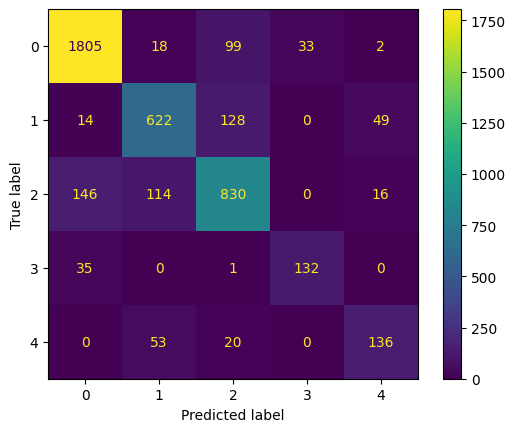

In [134]:
preds=dtc.predict(X_test)
print("Acc =", accuracy_score(y_test, preds))
print(classification_report(y_test, preds))

ConfusionMatrixDisplay(
    confusion_matrix(y_test, preds)
).plot()